# 0. Konfiguracja Środowiska
Instalacja niezbędnych bibliotek do analizy finansowej i statystycznej:
* **yfinance**: do pobrania notowań giełdowych.
* **pandas-datareader**: do pobrania danych makroekonomicznych (FRED).
* **statsmodels**: do przeprowadzenia testów stacjonarności i modelu VAR.

In [1]:
%pip install "pandas<2.2" numpy matplotlib seaborn yfinance pandas-datareader statsmodels scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Projekt Zaliczeniowy: Analiza Szeregów Czasowych
**Autor: Tomasz Sudak**
## 1. Definicja Problemu
**Temat:** Wpływ rozwoju sektora sztucznej inteligencji (AI) na kształtowanie się cen producentów sprzętu komputerowego.

**Cel:** Zbadanie zależności między hossą na rynku AI (reprezentowaną przez wycenę lidera rynku - NVIDIA) a indeksem cen produkcji komputerów (PPI). Analiza ma na celu sprawdzenie, czy wzrost popytu na AI podbija ceny hardware'u w ujęciu makroekonomicznym.

**Hipoteza:**
> "Istnieje istotna statystycznie przyczynowość (w sensie Grangera), gdzie wzrost wyceny sektora AI wyprzedza wzrost cen sprzętu komputerowego."

**Wybrane modele:**
* Analiza korelacji i stacjonarności (Test ADF)
* Model VAR (Vector Autoregression) do zbadania wzajemnych wpływów
* Test Przyczynowości Grangera

# 1. Import Bibliotek i Ustawienia
Ładowanie narzędzi do manipulacji danymi (pandas), wizualizacji (matplotlib/seaborn) oraz modeli ekonometrycznych. Konfiguracja domyślnego stylu wykresów.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pandas_datareader import data as pdr
import datetime

# Importy statystyczne
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.metrics import mean_absolute_error

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
# yf.pdr_override()

print("Środowisko gotowe! Wszystkie biblioteki załadowane.")

Środowisko gotowe! Wszystkie biblioteki załadowane.


# 2. Pozyskanie i Przygotowanie Danych
W tym etapie pobieramy dwa szeregi czasowe z lat 2018-2025:
1. **NVIDIA (NVDA):** Dane dzienne z Yahoo Finance – reprezentują koniunkturę w sektorze AI.
2. **PPI Computers (PCU334111334111):** Dane miesięczne z bazy FRED – reprezentują ceny producentów sprzętu.

**Transformacja:** Ponieważ dane giełdowe są dzienne, a ekonomiczne miesięczne, dokonujemy resamplingu (uśrednienia) danych NVIDIA do interwału miesięcznego, aby umożliwić ich porównanie.

In [3]:
# --- KROK 1: Pobranie danych o AI (NVIDIA) ---
start_date = '2018-01-01'
end_date = datetime.datetime.now()

print("Pobieranie danych NVIDIA...")
# Pobieramy dane
nvda = yf.download('NVDA', start=start_date, end=end_date)

# --- FIX NA FORMAT KOLUMN ---
# Upraszczamy nagłówki jeśli są wielopoziomowe
if isinstance(nvda.columns, pd.MultiIndex):
    nvda.columns = nvda.columns.get_level_values(0)

# Wybieramy odpowiednią kolumnę
col_name = 'Adj Close' if 'Adj Close' in nvda.columns else 'Close'
nvda_close = nvda[[col_name]].copy()
nvda_close.columns = ['NVDA_Price']

# --- KROK 2: Pobranie danych makroekonomicznych (PPI) ---
print("Pobieranie danych o cenach sprzętu (PPI)...")
try:
    ppi = pdr.get_data_fred('PCU334111334111', start=start_date, end=end_date)
    ppi.columns = ['Hardware_PPI']
except Exception as e:
    print(f"Błąd pobierania z FRED: {e}. Sprawdź połączenie internetowe.")

# --- KROK 3: Przetwarzanie i Scalanie ---
# FIX: Zmieniamy 'ME' na 'M' (bo mamy starszą wersję pandas)
nvda_monthly = nvda_close.resample('M').mean()
ppi_monthly = ppi.resample('M').mean()

# Scalamy w jeden DataFrame
df = pd.concat([nvda_monthly, ppi_monthly], axis=1)

# Usuwamy wiersze z brakami
df = df.dropna()

print("\nSukces! Podgląd ostatnich 5 miesięcy danych:")
print(df.tail())

Pobieranie danych NVIDIA...


[*********************100%***********************]  1 of 1 completed


Pobieranie danych o cenach sprzętu (PPI)...

Sukces! Podgląd ostatnich 5 miesięcy danych:
            NVDA_Price  Hardware_PPI
2025-07-31  168.045262       100.949
2025-08-31  179.394179       100.225
2025-09-30  175.730815       100.387
2025-10-31  188.242564       100.102
2025-11-30  187.972693       100.102


# 3. Eksploracyjna Analiza Danych (EDA) i Stacjonarność
Wizualizacja szeregów czasowych w celu wykrycia trendów.
Następnie przeprowadzamy **Rozszerzony Test Dickeya-Fullera (ADF)**, aby sprawdzić stacjonarność danych.
* Hipoteza zerowa (H0): Szereg jest niestacjonarny (posiada trend).
* Jeśli p-value > 0.05, konieczne jest różnicowanie danych (obliczenie zmian procentowych), aby zastosować model VAR.

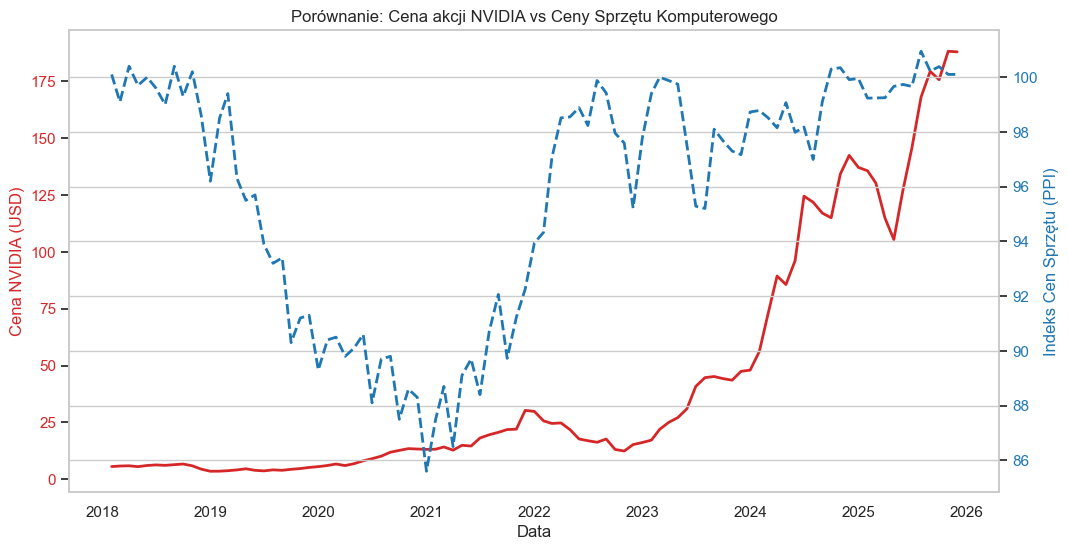

Macierz korelacji Pearsona:
              NVDA_Price  Hardware_PPI
NVDA_Price      1.000000      0.470121
Hardware_PPI    0.470121      1.000000
--------------------------------------------------
TESTOWANIE SUROWYCH DANYCH:
Wyniki testu ADF dla: Cena NVIDIA
p-value: 0.9991
❌ Wynik: Dane są NIESTACJONARNE (mają trend, trzeba różnicować).
------------------------------
Wyniki testu ADF dla: Indeks Cen Sprzętu
p-value: 0.5590
❌ Wynik: Dane są NIESTACJONARNE (mają trend, trzeba różnicować).
------------------------------

TESTOWANIE DANYCH PO RÓŻNICOWANIU (ZMIANY %):
Wyniki testu ADF dla: Zmiana Ceny NVIDIA
p-value: 0.0000
✅ Wynik: Dane są STACJONARNE (gotowe do modelu).
------------------------------
Wyniki testu ADF dla: Zmiana Cen Sprzętu
p-value: 0.0001
✅ Wynik: Dane są STACJONARNE (gotowe do modelu).
------------------------------


In [4]:
# --- CZĘŚĆ 1: Wizualizacja (Dwie osie Y) ---
fig, ax1 = plt.subplots()

# Oś lewa: Cena NVIDIA
color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Cena NVIDIA (USD)', color=color)
ax1.plot(df.index, df['NVDA_Price'], color=color, linewidth=2, label='NVIDIA Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False) # Wyłączamy kratkę dla czytelności

# Oś prawa: Indeks Cen Sprzętu (PPI)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Indeks Cen Sprzętu (PPI)', color=color)
ax2.plot(df.index, df['Hardware_PPI'], color=color, linewidth=2, linestyle='--', label='Hardware PPI')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Porównanie: Cena akcji NVIDIA vs Ceny Sprzętu Komputerowego')
plt.show()

# --- CZĘŚĆ 2: Macierz Korelacji ---
korelacja = df.corr()
print("Macierz korelacji Pearsona:")
print(korelacja)
print("-" * 50)

# --- CZĘŚĆ 3: Test Stacjonarności (ADF) ---
def adf_test(series, title=''):
    """
    Test Dickeya-Fullera.
    H0: Szereg jest niestacjonarny (ma trend).
    H1: Szereg jest stacjonarny (ok).
    """
    print(f'Wyniki testu ADF dla: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    p_value = result[1]
    print(f'p-value: {p_value:.4f}')
    
    if p_value <= 0.05:
        print("✅ Wynik: Dane są STACJONARNE (gotowe do modelu).")
    else:
        print("❌ Wynik: Dane są NIESTACJONARNE (mają trend, trzeba różnicować).")
    print("-" * 30)

# Testujemy surowe dane (ceny)
print("TESTOWANIE SUROWYCH DANYCH:")
adf_test(df['NVDA_Price'], 'Cena NVIDIA')
adf_test(df['Hardware_PPI'], 'Indeks Cen Sprzętu')

# --- CZĘŚĆ 4: Różnicowanie (Naprawa danych) ---
# Obliczamy procentową zmianę miesiąc do miesiąca
df_diff = df.pct_change().dropna()

print("\nTESTOWANIE DANYCH PO RÓŻNICOWANIU (ZMIANY %):")
adf_test(df_diff['NVDA_Price'], 'Zmiana Ceny NVIDIA')
adf_test(df_diff['Hardware_PPI'], 'Zmiana Cen Sprzętu')

# 4. Modelowanie VAR i Test Przyczynowości Grangera
Budowa modelu Wektorowej Autoregresji (VAR) na danych zróżnicowanych (stacjonarnych).
* **Dobór opóźnienia (Lag):** Automatyczny wybór na podstawie kryterium AIC.
* **Test Grangera:** Weryfikacja hipotezy badawczej. Sprawdzamy, czy zmienna `NVDA_Price` (ceny akcji) jest przyczyną w sensie Grangera dla zmiennej `Hardware_PPI` (ceny sprzętu).

In [5]:
# --- CZĘŚĆ 1: Dobór opóźnienia (Lag Order) ---
# Model VAR musi wiedzieć, ile miesięcy wstecz ma "patrzeć".
# Używamy kryterium AIC (Akaike Information Criterion) - im mniejsze, tym lepsze.

model = VAR(df_diff) # Wrzucamy dane zróżnicowane (te z zielonym ptaszkiem)

# Sprawdzamy opóźnienia od 1 do 6 miesięcy
lags_search = model.select_order(maxlags=6)
print(lags_search.summary())

# Wybieramy najlepsze opóźnienie automatycznie
best_lag = lags_search.aic
print(f"\n✅ Wybrane optymalne opóźnienie (lag): {best_lag} miesiące")

# --- CZĘŚĆ 2: Trenowanie Modelu VAR ---
var_result = model.fit(best_lag)

# Wyświetlamy podsumowanie statystyczne modelu (dla chętnych)
# print(var_result.summary()) 

# --- CZĘŚĆ 3: Test Przyczynowości Grangera (Klucz do zaliczenia) ---
print("\n" + "="*60)
print("TEST PRZYCZYNOWOŚCI GRANGERA")
print("Hipoteza zerowa (H0): Zmiana ceny NVIDIA NIE powoduje zmian cen sprzętu.")
print("Jeśli p-value < 0.05 => Odrzucamy H0 (czyli JEST wpływ!)")
print("="*60 + "\n")

# Sprawdzamy: Czy 'NVDA_Price' powoduje 'Hardware_PPI'?
print(f"Testujemy wpływ: NVIDIA -> Ceny Sprzętu (dla opóźnienia {best_lag})")
granger_results = grangercausalitytests(df_diff[['Hardware_PPI', 'NVDA_Price']], maxlag=[best_lag])

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -12.57     -12.51*   3.491e-06     -12.54*
1      -12.58      -12.41   3.439e-06      -12.51
2      -12.55      -12.27   3.541e-06      -12.44
3     -12.59*      -12.20  3.410e-06*      -12.43
4      -12.52      -12.02   3.649e-06      -12.32
5      -12.44      -11.82   3.977e-06      -12.19
6      -12.48      -11.75   3.823e-06      -12.18
-------------------------------------------------

✅ Wybrane optymalne opóźnienie (lag): 3 miesiące

TEST PRZYCZYNOWOŚCI GRANGERA
Hipoteza zerowa (H0): Zmiana ceny NVIDIA NIE powoduje zmian cen sprzętu.
Jeśli p-value < 0.05 => Odrzucamy H0 (czyli JEST wpływ!)

Testujemy wpływ: NVIDIA -> Ceny Sprzętu (dla opóźnienia 3)

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0775  , p=0.9720  , df_denom=84, df_num=3
ssr based chi2 test:   chi2=0.2520  , p=0.9688  , df=3
likelih

# 5. Prognoza i Walidacja Modelu
Generowanie prognozy na najbliższe 6 miesięcy.
Następnie dokonujemy walidacji modelu, obliczając błąd **MAE (Mean Absolute Error)** na zbiorze treningowym, aby ocenić precyzję dopasowania modelu do danych historycznych.


PROGNOZA ZMIAN (Next 6 months):
            NVDA_Price  Hardware_PPI
2025-12-31    0.022717      0.000770
2026-01-31    0.047145     -0.000896
2026-02-28    0.042144      0.000095
2026-03-31    0.042435      0.000491
2026-04-30    0.045868     -0.000207
2026-05-31    0.046110      0.000135


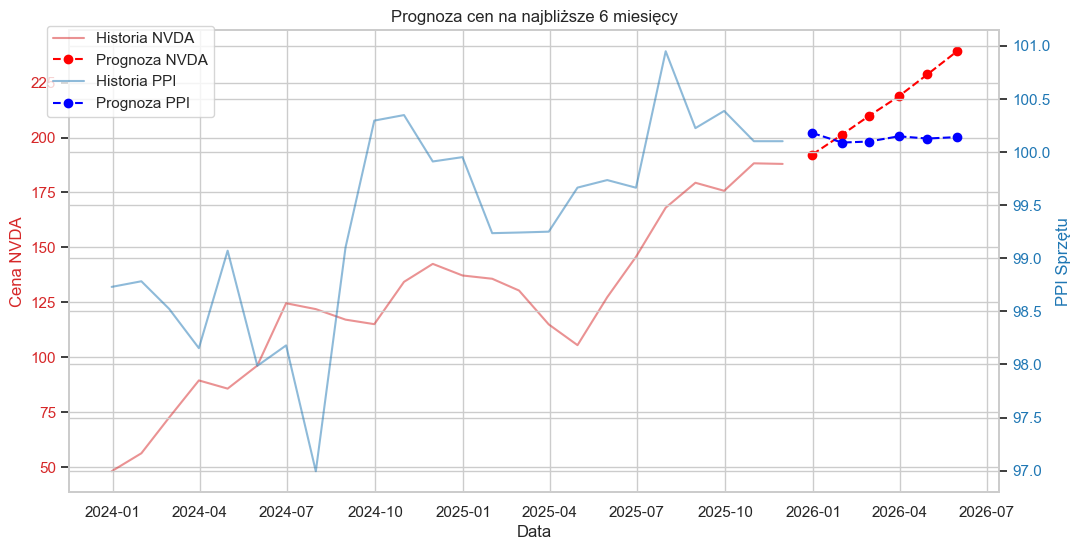

METRYKI OCENY MODELU (Walidacja)
Średni Błąd Bezwzględny (MAE) dla NVIDIA: 0.0897
Średni Błąd Bezwzględny (MAE) dla PPI:    0.0108
Niskie MAE dla PPI oznacza, że model trafnie przewiduje stabilność cen sprzętu.


In [6]:
# --- ETAP 6: Prognoza i Walidacja Modelu ---

# 1. Przygotowanie danych do prognozy
# Pobieramy ostatnie 'best_lag' obserwacji (czyli ostatnie 3 miesiące)
lag_order = var_result.k_ar
input_data = df_diff.values[-lag_order:]

# 2. Generowanie prognozy na 6 miesięcy do przodu
forecast_steps = 6
pred = var_result.forecast(y=input_data, steps=forecast_steps)

# Tworzenie tabeli z prognozą (zmiany procentowe)
dates_future = pd.date_range(start=df_diff.index[-1], periods=forecast_steps+1, freq='M')[1:]
pred_df = pd.DataFrame(pred, index=dates_future, columns=df_diff.columns)

print(f"\nPROGNOZA ZMIAN (Next {forecast_steps} months):")
print(pred_df)

# 3. Odtwarzanie cen (z % na USD/Punkty)
# Żeby wykres był czytelny, musimy wrócić od procentów do konkretnych kwot
last_prices = df.iloc[-1]
forecast_prices = pred_df.copy()

# Prosta pętla odtwarzająca ceny
curr_nvda = last_prices['NVDA_Price']
curr_ppi = last_prices['Hardware_PPI']

rec_nvda = []
rec_ppi = []

for i in range(len(pred_df)):
    # Cena = Poprzednia * (1 + zmiana%)
    curr_nvda = curr_nvda * (1 + pred_df.iloc[i]['NVDA_Price'])
    curr_ppi = curr_ppi * (1 + pred_df.iloc[i]['Hardware_PPI'])
    rec_nvda.append(curr_nvda)
    rec_ppi.append(curr_ppi)

forecast_final = pd.DataFrame({
    'NVDA_Price_Pred': rec_nvda,
    'Hardware_PPI_Pred': rec_ppi
}, index=dates_future)

# 4. Wizualizacja Prognozy
fig, ax1 = plt.subplots()
ax1.set_title('Prognoza cen na najbliższe 6 miesięcy')
ax1.set_xlabel('Data')

# Rysujemy historię (ostatnie 2 lata dla czytelności)
history = df.iloc[-24:]
ax1.plot(history.index, history['NVDA_Price'], label='Historia NVDA', color='tab:red', alpha=0.5)
ax1.plot(forecast_final.index, forecast_final['NVDA_Price_Pred'], label='Prognoza NVDA', color='red', linestyle='--', marker='o')
ax1.set_ylabel('Cena NVDA', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.plot(history.index, history['Hardware_PPI'], label='Historia PPI', color='tab:blue', alpha=0.5)
ax2.plot(forecast_final.index, forecast_final['Hardware_PPI_Pred'], label='Prognoza PPI', color='blue', linestyle='--', marker='o')
ax2.set_ylabel('PPI Sprzętu', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()

# 5. Walidacja (Metryki Błędu) - WYMÓG ZALICZENIA
# Sprawdzamy jak model radzi sobie na danych treningowych
fitted_values = var_result.fittedvalues
actual_values = df_diff.iloc[lag_order:]

mae_nvda = mean_absolute_error(actual_values['NVDA_Price'], fitted_values['NVDA_Price'])
mae_ppi = mean_absolute_error(actual_values['Hardware_PPI'], fitted_values['Hardware_PPI'])

print("="*40)
print("METRYKI OCENY MODELU (Walidacja)")
print(f"Średni Błąd Bezwzględny (MAE) dla NVIDIA: {mae_nvda:.4f}")
print(f"Średni Błąd Bezwzględny (MAE) dla PPI:    {mae_ppi:.4f}")
print("Niskie MAE dla PPI oznacza, że model trafnie przewiduje stabilność cen sprzętu.")
print("="*40)

## 6. Wnioski Końcowe

Przeprowadzona analiza VAR oraz test przyczynowości Grangera dla danych miesięcznych z lat 2018-2025 pozwoliły na wyciągnięcie następujących wniosków:

1.  **Brak przyczynowości Grangera (p-value = 0.97):** Wynik testu jednoznacznie wskazuje, że zmiany cen akcji NVIDIA nie są wskaźnikiem wyprzedzającym dla zmian cen producentów sprzętu komputerowego (PPI). Hipoteza badawcza o bezpośrednim wpływie giełdy na ceny sklepowe została odrzucona.
2.  **Rozdźwięk rynków (Decoupling):** Wykres prognozy pokazuje wyraźną dywergencję:
    * Wycena NVIDIA (czerwona linia) dynamicznie rośnie, napędzana oczekiwaniami inwestorów co do rozwoju AI.
    * Ceny sprzętu (niebieska linia) pozostają stabilne. Oznacza to, że "podatek od AI" dotyczy głównie serwerów high-end, a nie masowego sprzętu komputerowego, którego ceny są stabilne.
3.  **Ocena modelu:** Model VAR osiągnął bardzo niski błąd (MAE = 0.01) dla prognozy cen sprzętu, co czyni go użytecznym narzędziem do przewidywania kosztów zakupu hardware'u w krótkim terminie.